In [4]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### [Volume Sampling for Linear Regression](https://arxiv.org/abs/1705.06908)
#### by [Michał Derezinski](https://users.soe.ucsc.edu/~mderezin/) and [Manfred K. Warmuth](https://users.soe.ucsc.edu/~manfred/)

This paper analyzes the problem of how to subsample data without significant degradation to the least squares estimator.  We are interested in the quantity $$ \hat{\mathbf{w}} = \mathbb{E}_{q(\mathbf{X}_{s}, \mathbf{y}_{s} | \mathbf{X}, \mathbf{y})}\left [\frac{\mathbf{X}_{s}^{T}\mathbf{y}_{s}}{\mathbf{X}_{s}^{T} \mathbf{X}_{s}} \right ] \approx \frac{\mathbf{\hat{X}}_{s}^{T}\mathbf{\hat{y}}_{s}}{\mathbf{\hat{X}}_{s}^{T} \mathbf{\hat{X}}_{s}} $$ where the expectation is taken over a subsampling mechanism $\mathbf{\hat{X}}_{s}, \mathbf{\hat{y}}_{s} \sim q(\mathbf{X}_{s}, \mathbf{y}_{s} | \mathbf{X}, \mathbf{y})$, $\mathbf{X}_{s}$ is an $s\in[d,N]$-sized subsample of the feature matrix, $\mathbf{y}_{s}$ are the responses associated with $\mathbf{X}_{s}$, and $\hat{\mathbf{w}}$ is the ordinary least squares estimate.  Specifically, the paper address the question: how should we set $q$ to ensure a good Monte Carlo estimate?  The answer is *volume sampling*.  For $M$ disjoint subsamples $\{\mathbf{X}_{1,s},\ldots, \mathbf{X}_{m,s}, \ldots, \mathbf{X}_{M,s}\}$, all of size $s$, sample subsets according to: $$q(\mathbf{X}_{m,s}, \mathbf{y}_{m,s} | \mathbf{X}, \mathbf{y}) \propto | \mathbf{X}_{m,s}^{T} \mathbf{X}_{m,s} |$$ where $| \cdot |$ denotes the determinant.  The intuition behind the mechanism is that the determinant of the Gram feature matrix represents the [diversity](https://en.wikipedia.org/wiki/Determinantal_point_process) of the subset.  When the data is one-dimensional, sampling reduces to $ q(\mathbf{X}_{m,s}, \mathbf{y}_{m,s} | \mathbf{X}, \mathbf{y}) \propto \sum_{j=1}^{s} x_{m,j}^{2} $, and for single datapoints, we have $q(x_{i}|\mathbf{x},\mathbf{y}) \propto x_{i}^{2}$.  In the one-dimensional setting, we see that sampling large (absolute) values are desirable because they give the line its leverage.  Let's write some functions to calculate these quantities...    

In [23]:
def get_OLS_estimate(X, y):
    if len(X.shape) < 2:
        return np.dot(X,y)/np.dot(X,X)
    else:
        return np.dot(inv(np.dot(X.T, X) + .001*np.eye(X.shape[1])), np.dot(X.T, y))

def calc_subsample_probs(X, split_idxs):
    probs = []
    for idxs in split_idxs:
        X_s = X[idxs]
        if len(X.shape) < 2:
            probs.append(np.dot(X_s, X_s))
        else:
            probs.append(det(np.dot(X_s, X_s.T)))
        
    return np.array(probs)

### Experiment #1: One Dimensional Simulation

Let's simulate some one-dimensional data...

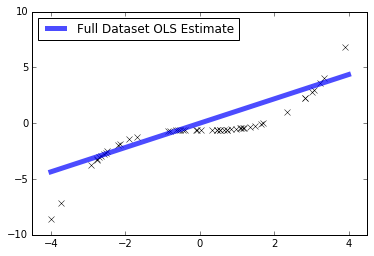

In [6]:
# Simulate data
N = 50
x = np.array([np.random.uniform(-4,4) for n in range(N)])
y = (x/2)**3 + np.random.normal() 

# Calculate OLS estimate
true_w_hat = get_OLS_estimate(x,y)

plt.plot(x, y, 'xk')
plt.plot([-4, 4], [-4*true_w_hat, 4*true_w_hat], 'b-', linewidth=5, alpha=.7, label="Full Dataset OLS Estimate")

plt.xlim([-4.5, 4.5])
plt.ylim([-10, 10])
plt.legend(loc=2)
plt.show()

Let's look at the distributions of lines estimated with using one data point...

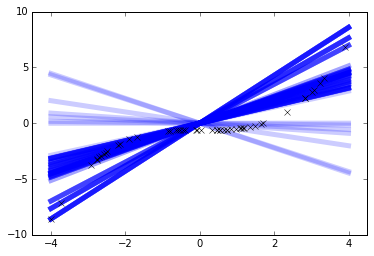

In [7]:
idx_probs = calc_subsample_probs(x, range(N))

for i in range(100):
    sampled_idx = np.argmax(np.log(idx_probs) + np.random.gumbel(size=(N,)))
    w_hat = get_OLS_estimate(x[sampled_idx], y[sampled_idx])
    plt.plot([-4, 4], [-4*w_hat, 4*w_hat], 'b-', linewidth=5, alpha=.2)
    
plt.plot(x, y, 'xk')
plt.xlim([-4.5, 4.5])
plt.ylim([-10, 10])
plt.show()

Now let's look at RMSE as subsample size grows...

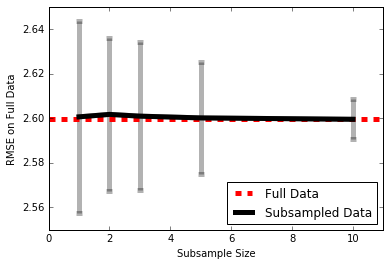

In [8]:
rmse_means = []
rmse_stds = []
split_sizes = [1, 2, 3, 5, 10]

for s in split_sizes:
    # make splits
    idxs = range(N)
    np.random.shuffle(idxs)
    idx_splits = [idxs[k*s:(k+1)*s] for k in range(N/s)]
        
    # get split probs
    idx_probs = calc_subsample_probs(x, idx_splits)
    
    rmse = []
    # draw multiple samples
    for rerun in range(5000):
        sampled_idx = np.argmax(np.log(idx_probs) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(x[idx_splits[sampled_idx]], y[idx_splits[sampled_idx]])
        rmse.append(np.sqrt(np.mean((y-np.sum(x*w_hat))**2)))
        
    rmse_means.append(np.mean(rmse))
    rmse_stds.append(np.std(rmse))
    
plt.plot([0,11], [np.sqrt(np.mean((y-np.sum(x*true_w_hat))**2))]*2, '--', color='red', markersize=10, mew=5, linewidth=5, label="Full Data")
plt.errorbar(split_sizes, rmse_means, yerr=rmse_stds, fmt='k-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, rmse_means, '-', color='black', markersize=10, mew=5, linewidth=5, label="Subsampled Data")

plt.xlabel("Subsample Size")
plt.ylabel("RMSE on Full Data")
plt.xlim([0, 11])
plt.legend(loc=4)
plt.show()

We see that the estimator is unbiased, as the RMSE estimate over multiple runs (black line) matches the RMSE calculated on the full dataset (red line).

### Experiment #2: Cover-Type Dataset

Next, let's use a real dataset...

In [44]:
def _split_data(data, split):

    N = data.shape[0]
    if sum(split) != N:
        const = int(np.ceil(N / float(sum(split))))
    else:
        const = 1
    starts = np.cumsum(np.r_[0, split[:-1]] * const)
    ends = np.cumsum(split) * const
    if ends[-1] > N:
        ends[-1] = N
    splits = [data[s:e] for s, e in zip(starts, ends)]
    return splits

# /Desktop/UCIdatasets/libsvm/covtype.libsvm.binary.scale
def load_libsvm_data(dataset, splitPer = .2):
    if dataset[1]:
        X_train, y_train = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[0])
        X_test, y_test = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[1])
    else:
        X, y = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[0])        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=splitPer, random_state=42)
    
    for y in [y_train, y_test]:
        for idx in xrange(len(y)):
            if y[idx] == -1: y[idx] = 0
            if y[idx] == 2: y[idx] = 0
            if y[idx] == 4: y[idx] = 1
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_libsvm_data(["covtype.libsvm.binary.scale", None])

In [45]:
# reduce train dataset to 10k
X_train = X_train[:10000, :].todense()
y_train = y_train[:10000][np.newaxis].T
X_test = X_test.todense()
y_test = y_test[np.newaxis].T

We'll run the same experiment as before (Subsample size vs RMSE) but measuring held-out data...

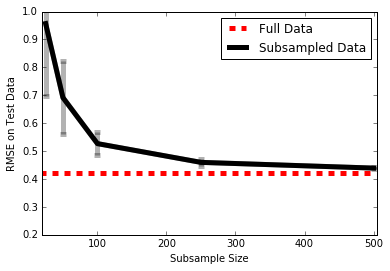

In [49]:
rmse_means = []
rmse_stds = []
split_sizes = [25, 50, 100, 250, 500]
N = X_train.shape[0]
true_w_hat = get_OLS_estimate(X_train, y_train)

for s in split_sizes:
    # make splits
    idxs = range(N)
    np.random.shuffle(idxs)
    idx_splits = [idxs[k*s:(k+1)*s] for k in range(N/s)]
        
    # get split probs
    idx_probs = calc_subsample_probs(X_train, idx_splits)
    
    rmse = []
    # draw multiple samples
    for rerun in range(100):
        sampled_idx = np.argmax(np.log(idx_probs + .00001) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(X_train[idx_splits[sampled_idx]], y_train[idx_splits[sampled_idx]])
        rmse.append(np.sqrt(np.mean(np.power(y_test-np.dot(X_test, w_hat),2))))
        
    rmse_means.append(np.mean(rmse))
    rmse_stds.append(np.std(rmse))
    
plt.plot([0,501], [np.sqrt(np.mean(np.power(y_test-np.dot(X_test, true_w_hat),2)))]*2, '--', color='red', markersize=10, mew=5, linewidth=5, label="Full Data")
plt.errorbar(split_sizes, rmse_means, yerr=rmse_stds, fmt='k-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, rmse_means, '-', color='black', markersize=10, mew=5, linewidth=5, label="Subsampled Data")

plt.xlabel("Subsample Size")
plt.ylabel("RMSE on Test Data")
plt.xlim([20, 505])
plt.ylim([0.2, 1])
plt.legend(loc=1)
plt.show()